# Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import copy
import functools
import gc
import itertools
import logging
import operator
import os
import pathlib
import re
import socket
import sys
import time
from collections import Counter
from dataclasses import asdict, dataclass, field
from enum import Enum
from functools import partial
from pathlib import Path
from pprint import PrettyPrinter, pprint
from typing import *

In [3]:
%autoreload 2

import humanize
import matplotlib
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import yaml
from matplotlib import cm, patches, pyplot as plt
from numpy import ndarray
from numpy.random import RandomState
from progressbar import progressbar as pbar
from pymicro.file import file_utils
from sklearn import metrics, metrics as met, model_selection, preprocessing
from skimage import measure as skimage_measure
import tabulate
from tensorflow import keras
from tensorflow.keras import (
    callbacks as keras_callbacks,
    layers,
    losses,
    metrics as keras_metrics,
    optimizers,
    utils,
)
from tqdm import tqdm
from yaml import YAMLObject

In [4]:
%autoreload 2

from tomo2seg import (
    analyse as tomo2seg_analyse,
    callbacks as tomo2seg_callbacks,
    data as tomo2seg_data,
    datasets as tomo2seg_datasets,
    hosts,
    losses as tomo2seg_losses,
    schedule as tomo2seg_schedule,
    slack,
    slackme,
    utils as tomo2seg_utils,
    viz as tomo2seg_viz,
    volume_sequence,
)
from tomo2seg.data import EstimationVolume, Volume
from tomo2seg.logger import add_file_handler, dict2str, logger
from tomo2seg.model import Model as Tomo2SegModel

In [5]:
# this registers a custom exception handler for the whole current notebook
get_ipython().set_custom_exc((Exception,), slackme.custom_exc)

In [6]:
logger.setLevel(logging.DEBUG)


# Host

In [7]:
this_host = hosts.hosts[socket.gethostname()]

# Args

In [8]:
# [manual-input]

@dataclass
class Args:
    this_nb_name: str
    volume_name: str
    volume_version: str
    partition: str  # its alias...
    
    random_state_seed: int = 42
    runid: int = field(default_factory=lambda: int(time.time()))

args = Args(
    this_nb_name = "compare-models-00.ipynb",
    volume_name=tomo2seg_datasets.VOLUME_COMPOSITE_V1[0],
    volume_version=tomo2seg_datasets.VOLUME_COMPOSITE_V1[1],
    partition="test",
)

In [9]:
logger.debug(f"args\n{dict2str(asdict(args))}")

DEBUG::tomo2seg::{<ipython-input-9-d1573204856a>:<module>:001}::[2020-12-17::12:42:56.998]
args
{   'partition': 'test',
    'random_state_seed': 42,
    'runid': 1608205376,
    'this_nb_name': 'compare-models-00.ipynb',
    'volume_name': 'PA66GF30',
    'volume_version': 'v1'}



# estimation volumes

In [48]:
volume_fullname = tomo2seg_data.Volume.name_pieces2fullname(name=args.volume_name, version=args.volume_version)

logger.debug(f"{volume_fullname=}")

DEBUG::tomo2seg::{<ipython-input-48-7c2dbe905f3c>:<module>:003}::[2020-12-17::15:32:39.305]
volume_fullname='PA66GF30.v1'



In [49]:
datadir_paths = [
    tomo2seg_data.data_dir / name
    for name in os.listdir(tomo2seg_data.data_dir)
]

estimation_volumes = []

for path in datadir_paths:
    
    try:
        ev = tomo2seg_data.EstimationVolume.from_fullname(path.name)
    
    except ValueError as ex:
        
        if "not an estimation volume" not in ex.args[0]:
            raise ex
            
        continue
    
    if ev.volume_fullname == volume_fullname and ev.partition.alias == args.partition:
        estimation_volumes.append(ev)
        
logger.info(f"{len(estimation_volumes)=}")

all_estimation_volumes = copy.deepcopy(estimation_volumes)

INFO::tomo2seg::{data.py:from_fullname:494}::[2020-12-17::15:32:39.402]
Creating volume object to get partition dimensions.

DEBUG::tomo2seg::{data.py:metadata:180}::[2020-12-17::15:32:39.403]
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

INFO::tomo2seg::{data.py:from_fullname:494}::[2020-12-17::15:32:39.424]
Creating volume object to get partition dimensions.

DEBUG::tomo2seg::{data.py:metadata:180}::[2020-12-17::15:32:39.425]
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

INFO::tomo2seg::{data.py:from_fullname:494}::[2020-12-17::15:32:39.447]
Creating volume object to get partition dimensions.

DEBUG::tomo2seg::{data.py:metadata:180}::[2020-12-17::15:32:39.447]
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

ERROR::tomo2seg::{data.py:from_fullname:457}::[2020-12-17::15:32:39.463]
not enough values 

# models

In [50]:
for ev in sorted(estimation_volumes, key=lambda x: x.model_name):
    print(f'"{ev.model_name}",')

"unet2d-sep.vanilla03-f16.fold000.1606-575-226",
"unet2d.crop112-f16.fold000.1607-533-765",
"unet2d.crop48-f16.fold000.1607-530-580",
"unet2d.vanilla02-f08.fold000.1606-431-664",
"unet2d.vanilla02-f16.fold000.1606-461-820",
"unet2d.vanilla03-f16.fold000.1606-505-109",
"unet2halfd-sep.crop112-f16.fold000.1607-789-290",
"unet2halfd-sep.vanilla03-f16.fold000.1606-729-672",
"unet2halfd.crop112-f16.fold000.1607-788-628",
"unet2halfd.vanilla03-f16.fold000.1606-683-705",
"unet3d.crop112-f12.fold000.1607-466-349",
"unet3d.crop304-f16.fold000.1607-790-699",
"unet3d.crop96-f08.fold000.1607-109-265",
"unet3d.vanilla03-f08.fold000.1606-842-005",
"unet3d.vanilla03-f16.fold000.1606-750-939",


In [51]:
# [manual-input]
models_to_compare = [
    "unet2d-sep.vanilla03-f16.fold000.1606-575-226",
    "unet2d.vanilla03-f16.fold000.1606-505-109",
    "unet2halfd-sep.vanilla03-f16.fold000.1606-729-672",
    "unet2halfd.vanilla03-f16.fold000.1606-683-705",
    "unet3d.vanilla03-f08.fold000.1606-842-005",
    "unet3d.vanilla03-f16.fold000.1606-750-939",
]

estimation_volumes = [
    ev
    for ev in estimation_volumes 
    if ev.model_name in models_to_compare
]

In [52]:
len(estimation_volumes)

6

In [53]:
def get_nparams(model_name):
    t2s_model = Tomo2SegModel.build_from_model_name(model_name)
    summary = t2s_model.summary_path.read_text()
    trainable_params_line = summary.split("\n")[-4]
    trainable_params_str = trainable_params_line.split(" ")[-1]
    return int("".join(trainable_params_str.split(",")))

In [54]:
def get_records(estimation_volumes, metrics=("jaccard", "f1", )):
    
    records = []

    metric_cols = {}

    for ev in estimation_volumes:

        record = {}

        record["model"] = ev.model_name
        record["nparams"] = get_nparams(ev.model_name)

        ev_classif_report = pd.read_csv(ev.classification_report_table_exact_csv_path).set_index("class/average")

        for m in metrics:

            mcols = metric_cols[m] = []

            for row in ev_classif_report.index:
                col = f"{m}.{row}"
                mcols.append(col)
                record[col] = ev_classif_report.loc[row][m]
                
        record["estimation_volume"] = ev.fullname
        records.append(record)
        
    return records
    

In [55]:
df = pd.DataFrame.from_records(get_records(estimation_volumes)).set_index("model")    

In [56]:
df.sort_index()

,nparams,jaccard.matrix,jaccard.fiber,jaccard.porosity,jaccard.macro,jaccard.micro,f1.matrix,f1.fiber,f1.porosity,f1.macro,f1.micro,estimation_volume
model,,,,,,,,,,,,
unet2d-sep.vanilla03-f16.fold000.1606-575-226,5021381,0.987656,0.952714,0.660743,0.867037,NaN,0.993790,0.975784,0.795720,0.921765,0.989755,vol=PA66GF30.v1.set=test.model=unet2d-sep.vani...
unet2d.vanilla03-f16.fold000.1606-505-109,13338339,0.988335,0.955137,0.686747,0.876739,NaN,0.994133,0.977054,0.814286,0.928491,0.990322,vol=PA66GF30.v1.set=test.model=unet2d.vanilla0...
unet2halfd-sep.vanilla03-f16.fold000.1606-729-672,5021645,0.987035,0.950900,0.650163,0.862699,NaN,0.993475,0.974832,0.787998,0.918768,0.989245,vol=PA66GF30.v1.set=test.model=unet2halfd-sep....
unet2halfd.vanilla03-f16.fold000.1606-683-705,13340067,0.987910,0.953669,0.669623,0.870401,NaN,0.993918,0.976285,0.802125,0.924110,0.989969,vol=PA66GF30.v1.set=test.model=unet2halfd.vani...
unet3d.vanilla03-f08.fold000.1606-842-005,10000035,0.986341,0.949016,0.586432,0.840596,NaN,0.993123,0.973841,0.739310,0.902091,0.988651,vol=PA66GF30.v1.set=test.model=unet3d.vanilla0...
unet3d.vanilla03-f16.fold000.1606-750-939,39982659,0.986356,0.949471,0.591205,0.842344,NaN,0.993131,0.974081,0.743091,0.903434,0.988669,vol=PA66GF30.v1.set=test.model=unet3d.vanilla0...


In [57]:
df.to_csv(sys.stdout)

model,nparams,jaccard.matrix,jaccard.fiber,jaccard.porosity,jaccard.macro,jaccard.micro,f1.matrix,f1.fiber,f1.porosity,f1.macro,f1.micro,estimation_volume
unet2halfd-sep.vanilla03-f16.fold000.1606-729-672,5021645,0.9870350222354484,0.950899642588346,0.6501625971163105,0.8626990873133683,,0.9934752142667492,0.9748319409467366,0.7879982230266055,0.9187684594133638,0.989244820019724,vol=PA66GF30.v1.set=test.model=unet2halfd-sep.vanilla03-f16.fold000.1606-729-672.runid=1608-021-400
unet3d.vanilla03-f16.fold000.1606-750-939,39982659,0.9863557720260464,0.9494708327165444,0.5912049598174871,0.8423438548533593,,0.9931310250831668,0.974080572822398,0.7430908962039672,0.9034341647031772,0.9886687475345168,vol=PA66GF30.v1.set=test.model=unet3d.vanilla03-f16.fold000.1606-750-939.runid=1607-518-433
unet3d.vanilla03-f08.fold000.1606-842-005,10000035,0.986340535475514,0.9490160010922576,0.5864322167416625,0.8405962511031447,,0.9931233017297229,0.9738411593957308,0.7393095154687699,0.902091325531408,0

# different crop sizes

In [58]:
# [manual-input]
models_to_compare = [
    "unet2d.crop48-f16.fold000.1607-530-580",
    "unet2d.crop112-f16.fold000.1607-533-765",
    "unet2d.vanilla03-f16.fold000.1606-505-109",

    "unet2halfd-sep.crop112-f16.fold000.1607-789-290",
    "unet2halfd-sep.vanilla03-f16.fold000.1606-729-672",

    "unet2halfd.crop112-f16.fold000.1607-788-628",
    "unet2halfd.vanilla03-f16.fold000.1606-683-705",
    
    "unet3d.crop96-f08.fold000.1607-109-265",
    "unet3d.crop112-f12.fold000.1607-466-349",
    "unet3d.crop304-f16.fold000.1607-790-699",
    "unet3d.vanilla03-f08.fold000.1606-842-005",
    "unet3d.vanilla03-f16.fold000.1606-750-939",
]

estimation_volumes_crops = [
    ev
    for ev in all_estimation_volumes 
    if ev.model_name in models_to_compare
] 

df_crops = pd.DataFrame.from_records(get_records(estimation_volumes_crops)).set_index("model")    

In [59]:
df_crops.sort_index().loc[[
    "unet3d.crop304-f16.fold000.1607-790-699",
    "unet3d.vanilla03-f16.fold000.1606-750-939",
    "unet2d.vanilla03-f16.fold000.1606-505-109",
]]

,nparams,jaccard.matrix,jaccard.fiber,jaccard.porosity,jaccard.macro,jaccard.micro,f1.matrix,f1.fiber,f1.porosity,f1.macro,f1.micro,estimation_volume
model,,,,,,,,,,,,
unet3d.crop304-f16.fold000.1607-790-699,39982659,0.987640,0.952945,0.658634,0.866406,NaN,0.993782,0.975906,0.794188,0.921292,0.989741,vol=PA66GF30.v1.set=test.model=unet3d.crop304-...
unet3d.vanilla03-f16.fold000.1606-750-939,39982659,0.986356,0.949471,0.591205,0.842344,NaN,0.993131,0.974081,0.743091,0.903434,0.988669,vol=PA66GF30.v1.set=test.model=unet3d.vanilla0...
unet2d.vanilla03-f16.fold000.1606-505-109,13338339,0.988335,0.955137,0.686747,0.876739,NaN,0.994133,0.977054,0.814286,0.928491,0.990322,vol=PA66GF30.v1.set=test.model=unet2d.vanilla0...


In [60]:
df_crops.to_csv(sys.stdout)

model,nparams,jaccard.matrix,jaccard.fiber,jaccard.porosity,jaccard.macro,jaccard.micro,f1.matrix,f1.fiber,f1.porosity,f1.macro,f1.micro,estimation_volume
unet2d.crop112-f16.fold000.1607-533-765,13338339,0.9876047829580394,0.9527990281306836,0.6509558367538262,0.8637865492808497,,0.9937637415907636,0.9758290683324952,0.7885805571077673,0.9193911223436754,0.9897086242603549,vol=PA66GF30.v1.set=test.model=unet2d.crop112-f16.fold000.1607-533-765.runid=1608-026-504
unet2halfd-sep.vanilla03-f16.fold000.1606-729-672,5021645,0.9870350222354484,0.950899642588346,0.6501625971163105,0.8626990873133683,,0.9934752142667492,0.9748319409467366,0.7879982230266055,0.9187684594133638,0.989244820019724,vol=PA66GF30.v1.set=test.model=unet2halfd-sep.vanilla03-f16.fold000.1606-729-672.runid=1608-021-400
unet3d.crop304-f16.fold000.1607-790-699,39982659,0.987640285337652,0.9529449198629022,0.658633673842883,0.866406293014479,,0.9937817145519124,0.975905577439224,0.7941882336403997,0.9212918418771786,0.989740

In [61]:
df_crops["estimation_volume"].values.tolist()

['vol=PA66GF30.v1.set=test.model=unet2d.crop112-f16.fold000.1607-533-765.runid=1608-026-504',
 'vol=PA66GF30.v1.set=test.model=unet2halfd-sep.vanilla03-f16.fold000.1606-729-672.runid=1608-021-400',
 'vol=PA66GF30.v1.set=test.model=unet3d.crop304-f16.fold000.1607-790-699.runid=1608-025-663',
 'vol=PA66GF30.v1.set=test.model=unet3d.vanilla03-f16.fold000.1606-750-939.runid=1607-518-433',
 'vol=PA66GF30.v1.set=test.model=unet2halfd.crop112-f16.fold000.1607-788-628.runid=1608-022-105',
 'vol=PA66GF30.v1.set=test.model=unet3d.crop96-f08.fold000.1607-109-265.runid=1608-024-748',
 'vol=PA66GF30.v1.set=test.model=unet2d.crop48-f16.fold000.1607-530-580.runid=1608-025-900',
 'vol=PA66GF30.v1.set=test.model=unet2halfd-sep.crop112-f16.fold000.1607-789-290.runid=1608-023-819',
 'vol=PA66GF30.v1.set=test.model=unet3d.vanilla03-f08.fold000.1606-842-005.runid=1607-521-380',
 'vol=PA66GF30.v1.set=test.model=unet3d.crop112-f12.fold000.1607-466-349.runid=1608-025-631',
 'vol=PA66GF30.v1.set=test.model=une

# training histories

In [169]:
def get_model_history(model_name):
    t2s_model = Tomo2SegModel.build_from_model_name(model_name)
    df = pd.read_csv(t2s_model.history_path).set_index("epoch")
    df["batches"] = df["train.epoch_size"].cumsum()
    df["crops"] = (df["train.epoch_size"] * df["train.batch_size"]).cumsum()
    import operator
    crop_nvoxels = functools.reduce(operator.mul, ast.literal_eval(amodel["train.crop_shape"][0]))
    df["voxels"] = (df["train.epoch_size"] * df["train.batch_size"] * crop_nvoxels).cumsum()
    df["seconds"] = df["seconds"].cumsum()
    df["hours"] = df["seconds"] / 60 / 60
    df["val_loss_cummin"] = np.array([
        df["val_loss"].values[:i].min()
        for i in [1] + list(range(1, df["val_loss"].shape[0])) 
    ])
    return df

In [209]:
dft_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

def plot(xaxis, yaxis, models_to_compare, color_map):
    
    hists = {
        mod: get_model_history(mod)
        for mod in models_to_compare
    }
    
    fig, axs = plt.subplots(
        nrows := 1, ncols := 2, figsize=(ncols * (sz := 6) * 2, nrows * sz), dpi=120,
    #     sharex=True,
        gridspec_kw=dict(hspace=sz/12, wspace=sz/36)
    )

    ax, axzoom = axs

    for mod, hist in hists.items():

        xs = hist[xaxis] if xaxis != "epoch" else hist.index
        ys = hist[yaxis]

        color = next(v for k, v in color_map.items() if k in mod)

        plot_kwargs = dict(
            label=mod,
            ls="--" if "sep" in mod else "-",
            color=color,
            linewidth=.7,
        )

        ax.plot(xs, ys, **plot_kwargs)
        axzoom.plot(xs, ys, **plot_kwargs)

    # configs in common
    for ax_ in axs:
        ax_.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
        ax_.set_ybound(lower=0)
        ax_.set_xlabel(xaxis)
        ax_.legend()
        ax_.set_ylabel("jaccard2 (lower is better)")

    ax.set_ybound(upper=.7)
    ax.set_title(f"{yaxis} history")

    axzoom.set_yscale("log")
    axzoom.set_ybound(upper=.03)
    axzoom.set_title("zoom")

## conv types

In [210]:
compare_conv_type = [
    "unet2d-sep.vanilla03-f16.fold000.1606-575-226",
    "unet2d.vanilla03-f16.fold000.1606-505-109",
    "unet2halfd-sep.vanilla03-f16.fold000.1606-729-672",
    "unet2halfd.vanilla03-f16.fold000.1606-683-705",
    "unet3d.vanilla03-f08.fold000.1606-842-005",
    "unet3d.vanilla03-f16.fold000.1606-750-939",
]

color_map = {
    "2d": dft_colors[0],
    "2halfd": dft_colors[1],
    "3d.vanilla03-f08": dft_colors[2],
    "3d.vanilla03-f16": dft_colors[3],
}

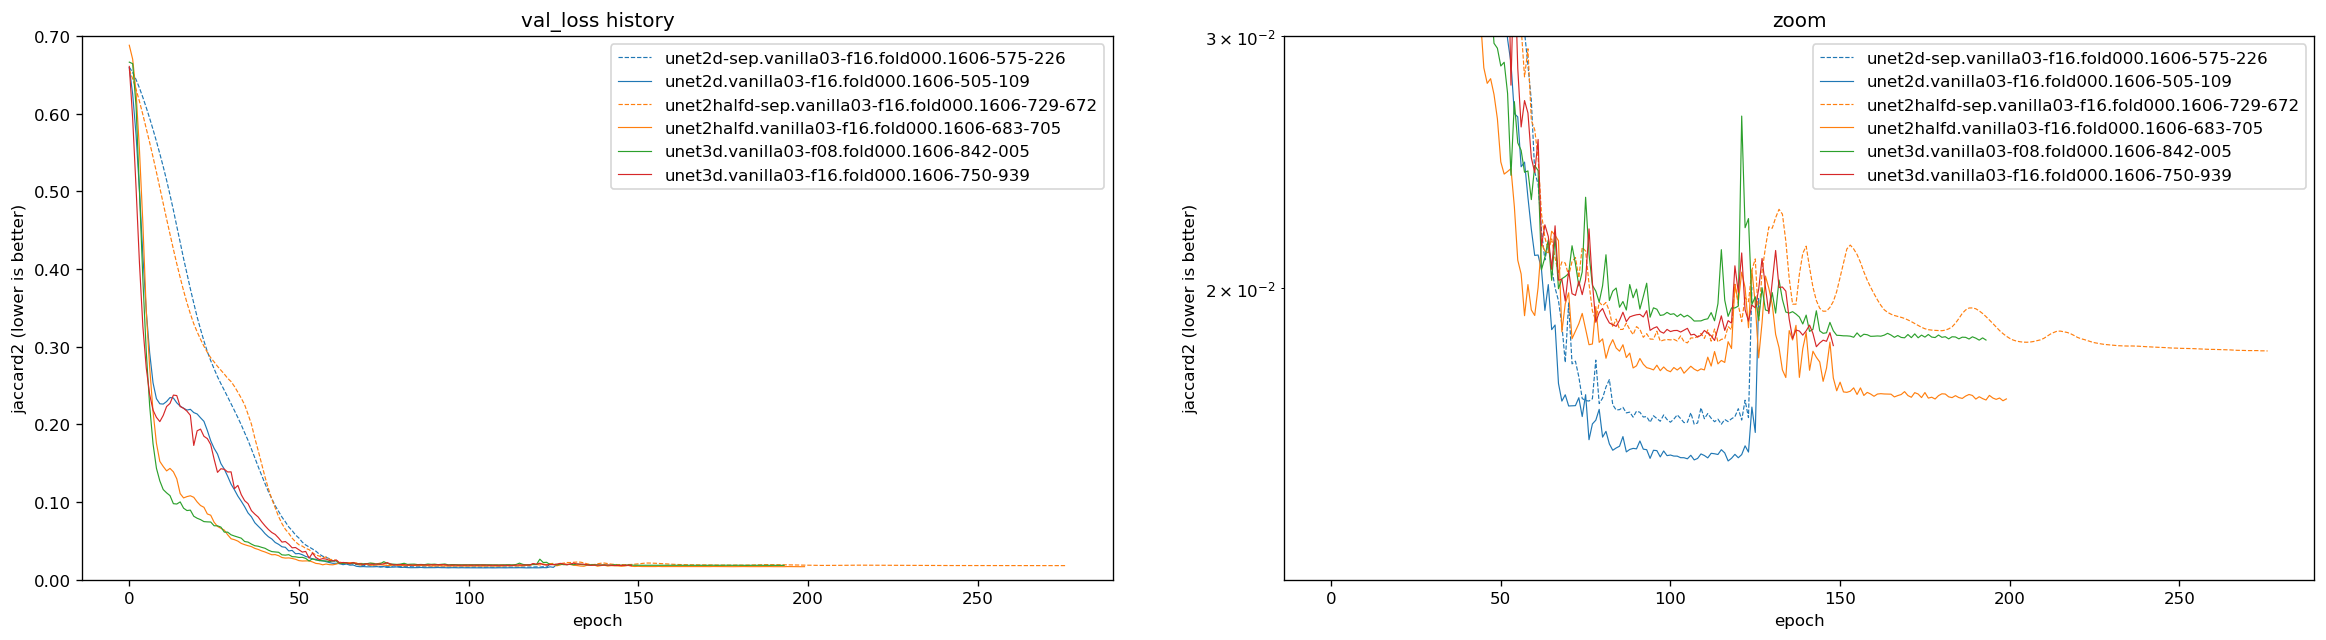

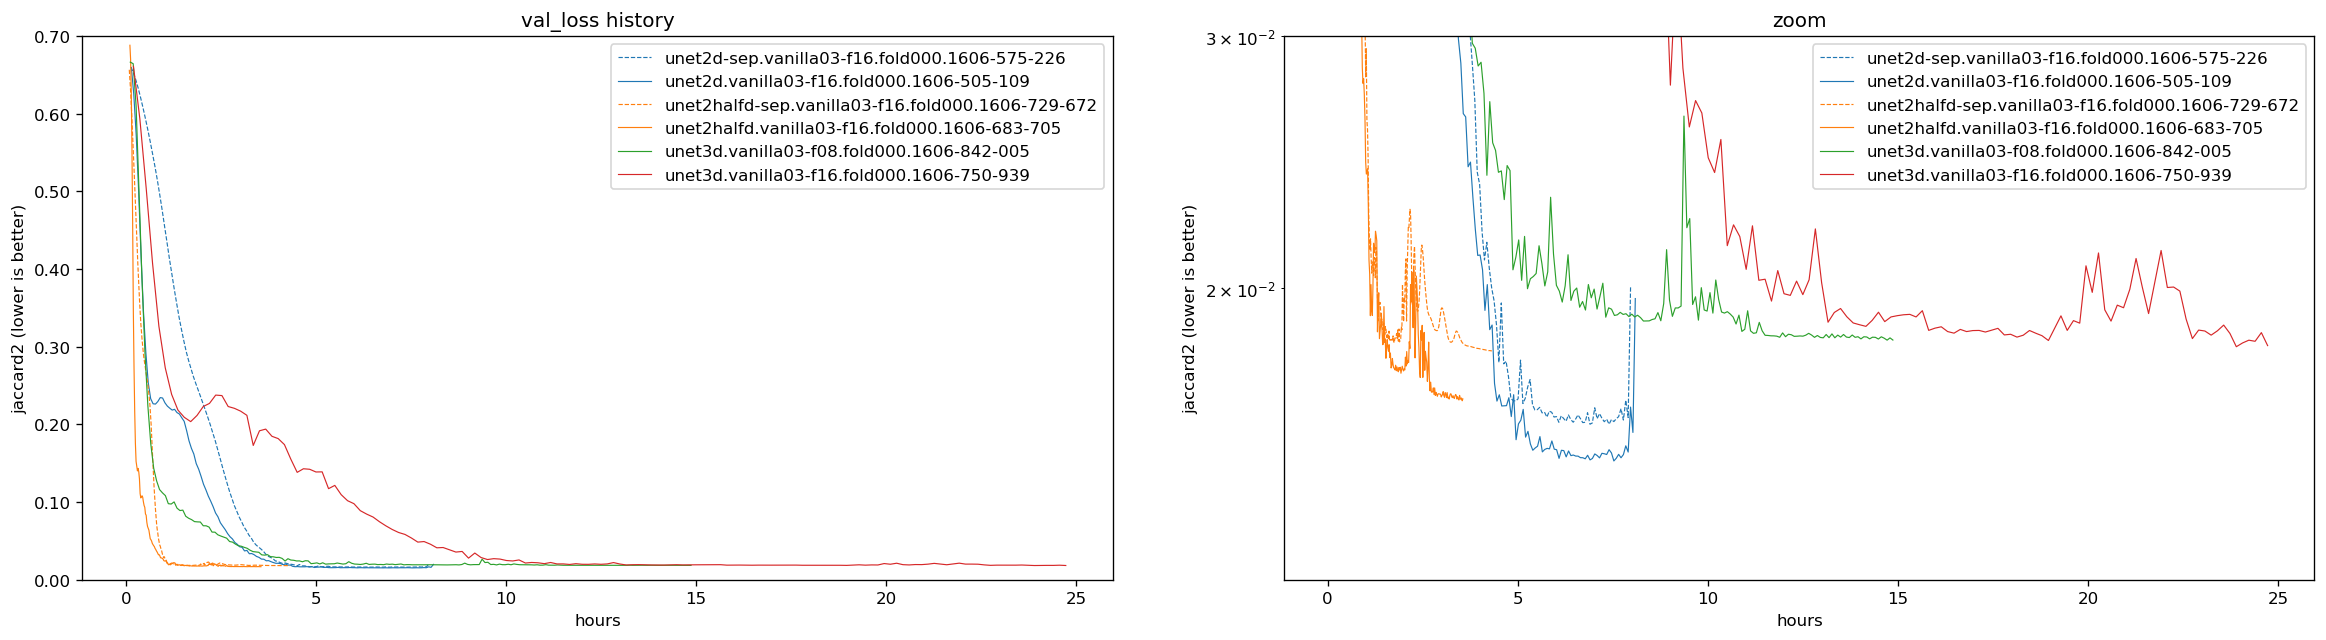

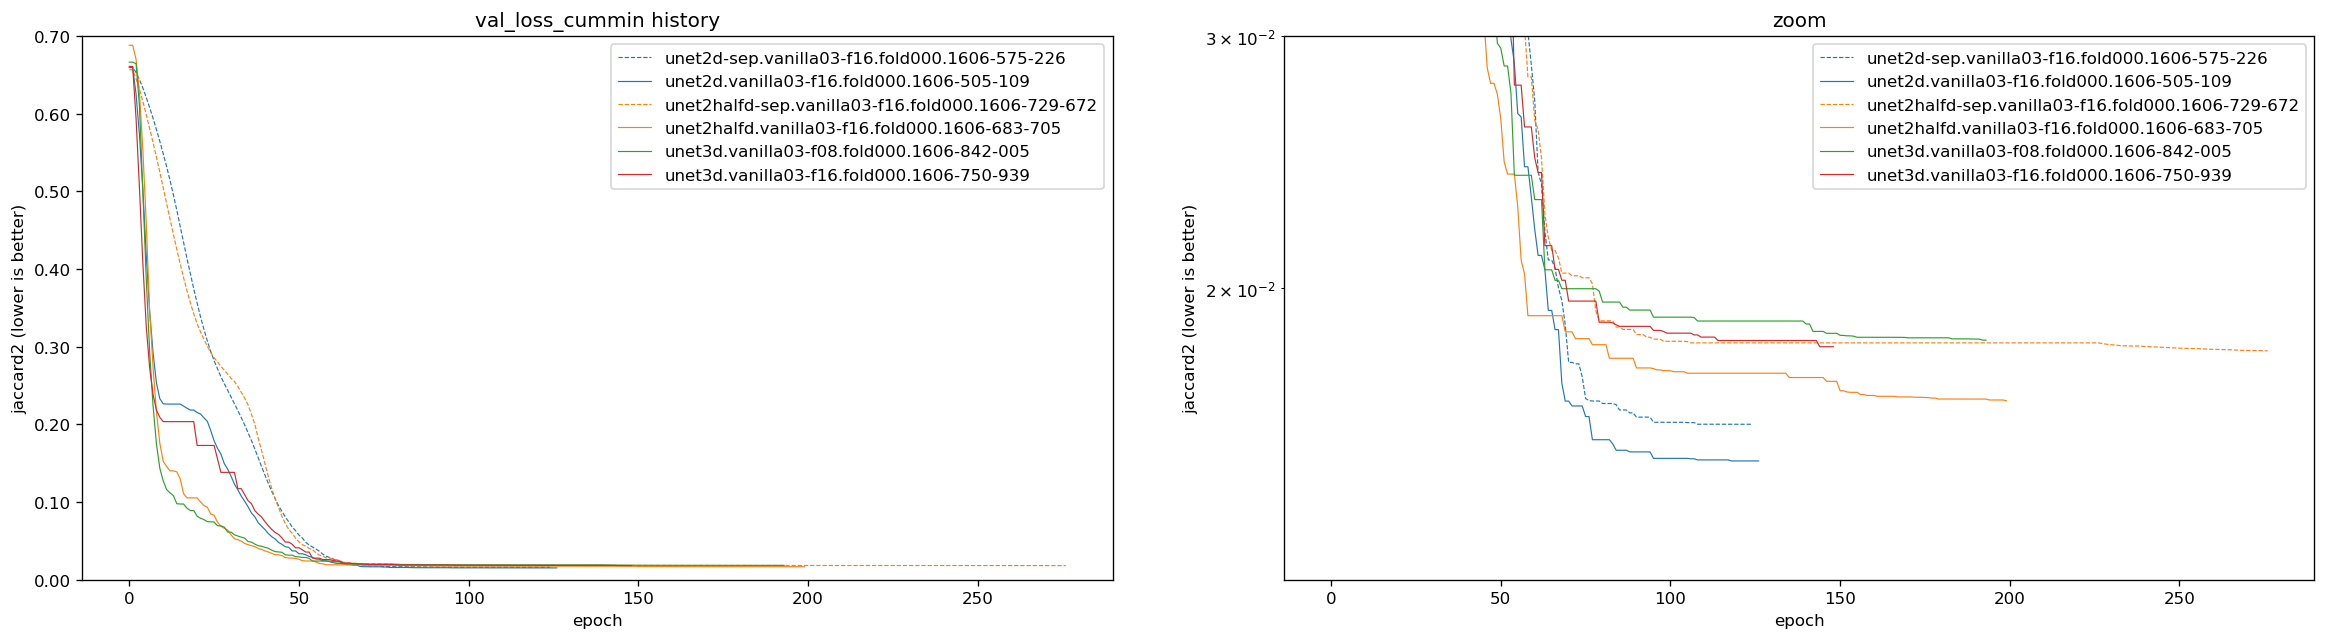

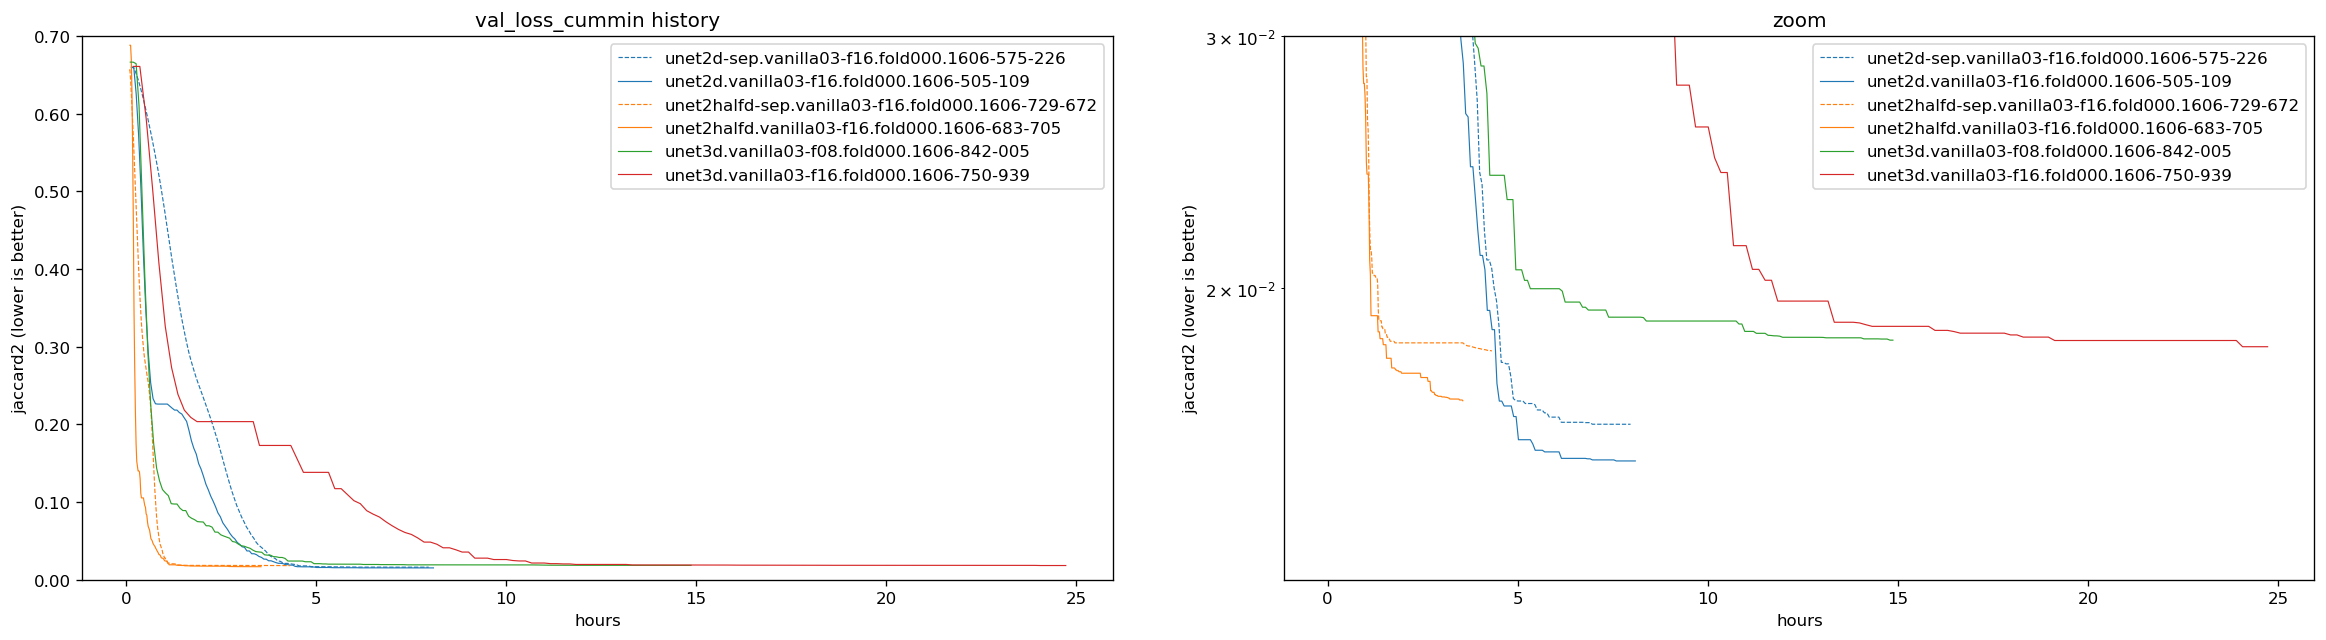

In [211]:
plot("epoch", "val_loss", compare_conv_type, color_map)
plot("hours", "val_loss", compare_conv_type, color_map)
plot("epoch", "val_loss_cummin", compare_conv_type, color_map)
plot("hours", "val_loss_cummin", compare_conv_type, color_map)

## crop sizes

### 2d

In [212]:
compare_crop_sizes = [
    "unet2d.crop48-f16.fold000.1607-530-580",
    "unet2d.crop112-f16.fold000.1607-533-765",
    "unet2d.vanilla03-f16.fold000.1606-505-109",
]

color_map = {
    "crop48": dft_colors[0],
    "crop112": dft_colors[1],
    "vanilla03": dft_colors[2],
}

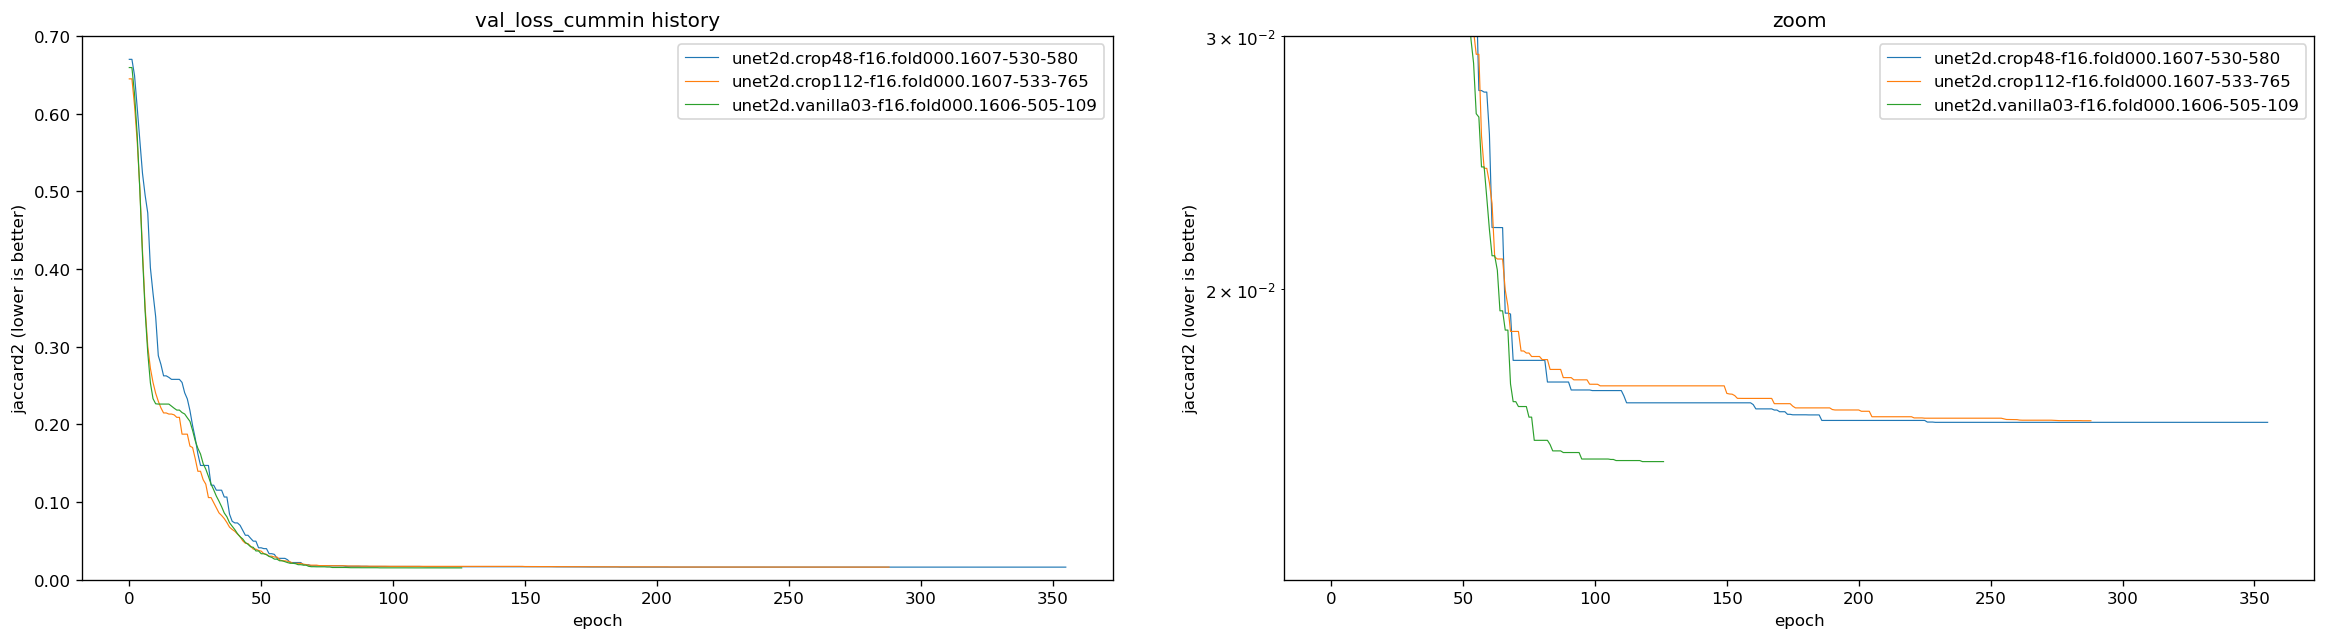

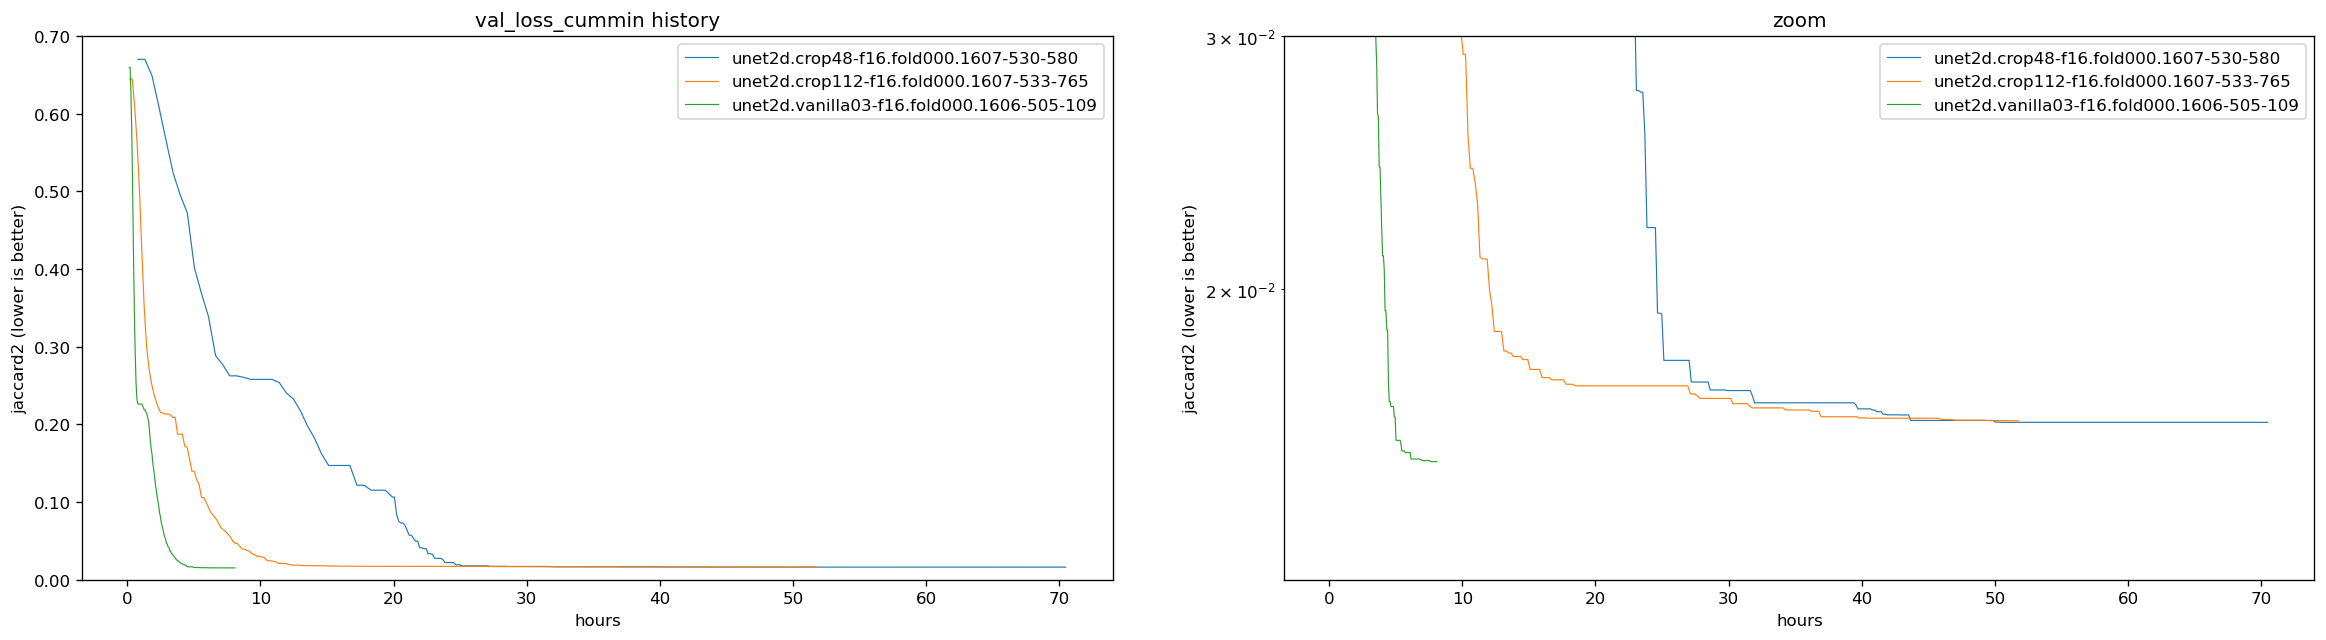

In [213]:
# plot("epoch", "val_loss", compare_crop_sizes, color_map)
# plot("hours", "val_loss", compare_crop_sizes, color_map)
plot("epoch", "val_loss_cummin", compare_crop_sizes, color_map)
plot("hours", "val_loss_cummin", compare_crop_sizes, color_map)

### 2.5d

In [214]:
compare_crop_sizes = [
    "unet2halfd.crop112-f16.fold000.1607-788-628",
    "unet2halfd.vanilla03-f16.fold000.1606-683-705",

    "unet2halfd-sep.crop112-f16.fold000.1607-789-290",
    "unet2halfd-sep.vanilla03-f16.fold000.1606-729-672",
]

color_map = {
    "crop112": dft_colors[1],
    "vanilla03": dft_colors[2],
}

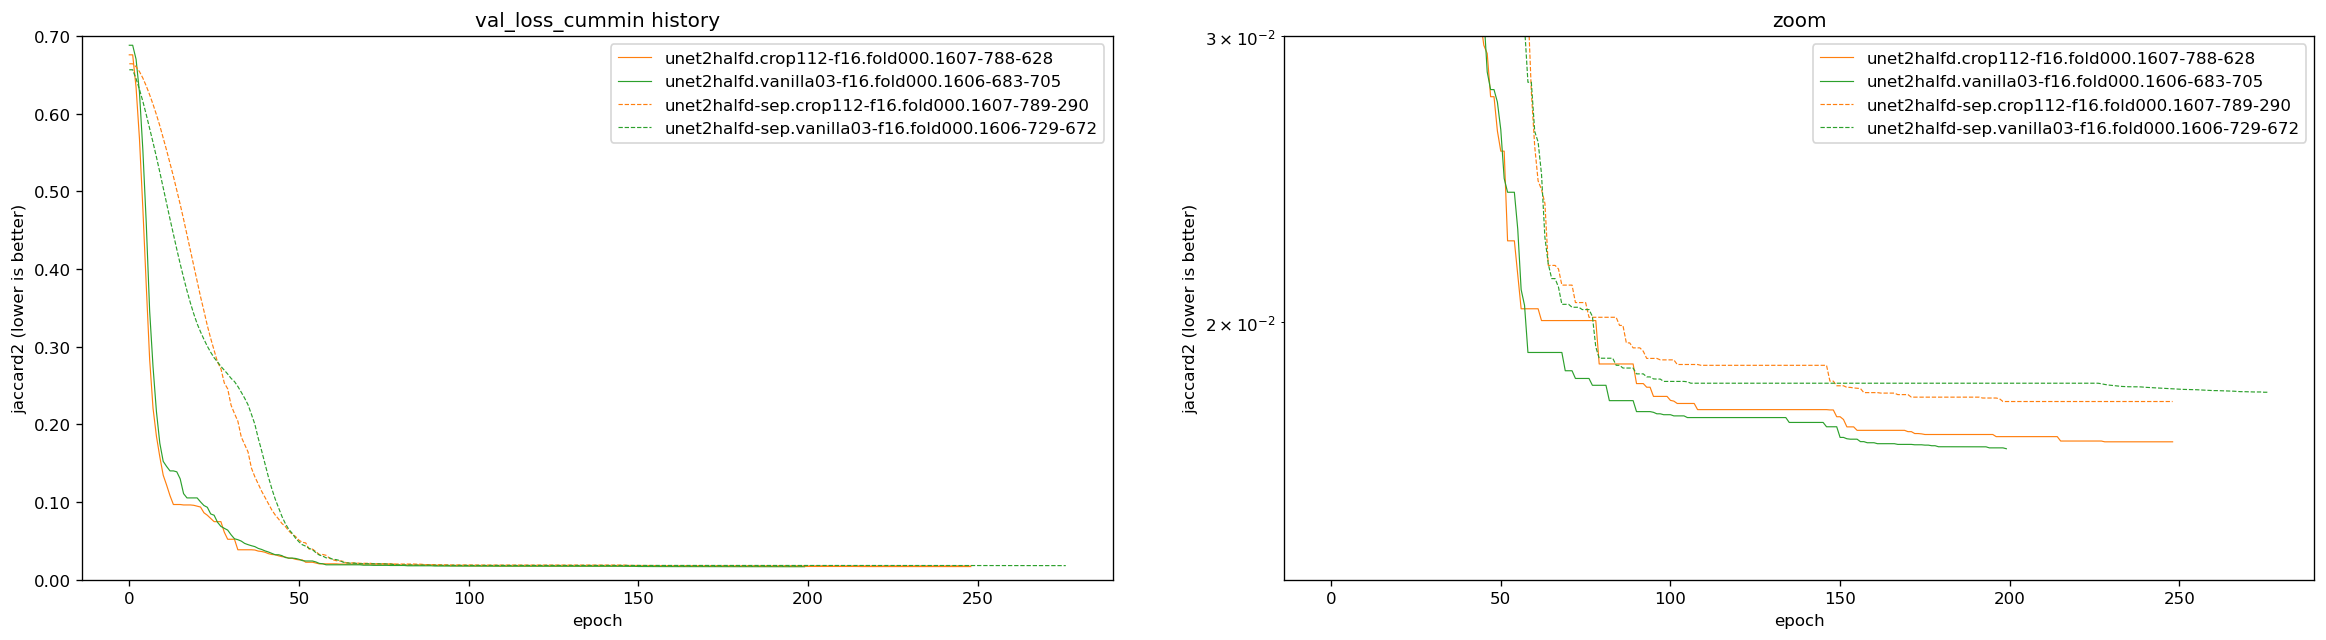

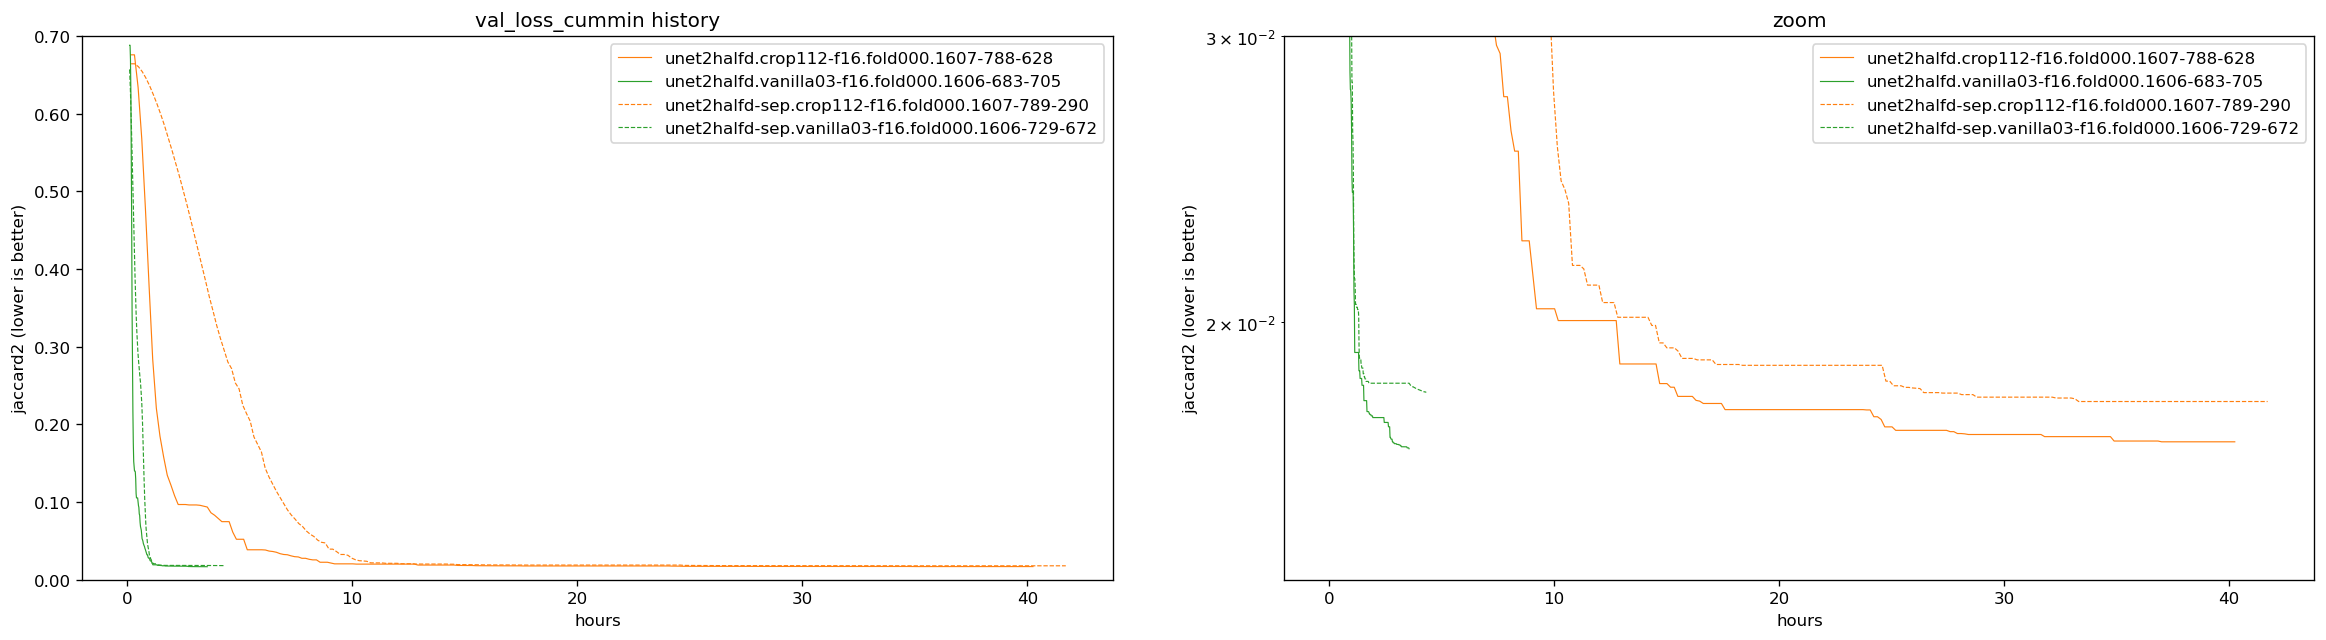

In [215]:
# plot("epoch", "val_loss", compare_crop_sizes, color_map)
# plot("hours", "val_loss", compare_crop_sizes, color_map)
plot("epoch", "val_loss_cummin", compare_crop_sizes, color_map)
plot("hours", "val_loss_cummin", compare_crop_sizes, color_map)

### 3d

In [216]:
compare_crop_sizes = [
    "unet3d.vanilla03-f08.fold000.1606-842-005",
    "unet3d.crop96-f08.fold000.1607-109-265",
    "unet3d.crop112-f12.fold000.1607-466-349",
    "unet3d.crop304-f16.fold000.1607-790-699",
]

color_map = {
    "vanilla03": dft_colors[0],
    "crop96": dft_colors[1],
    "crop112": dft_colors[2],
    "crop304": dft_colors[3],
}

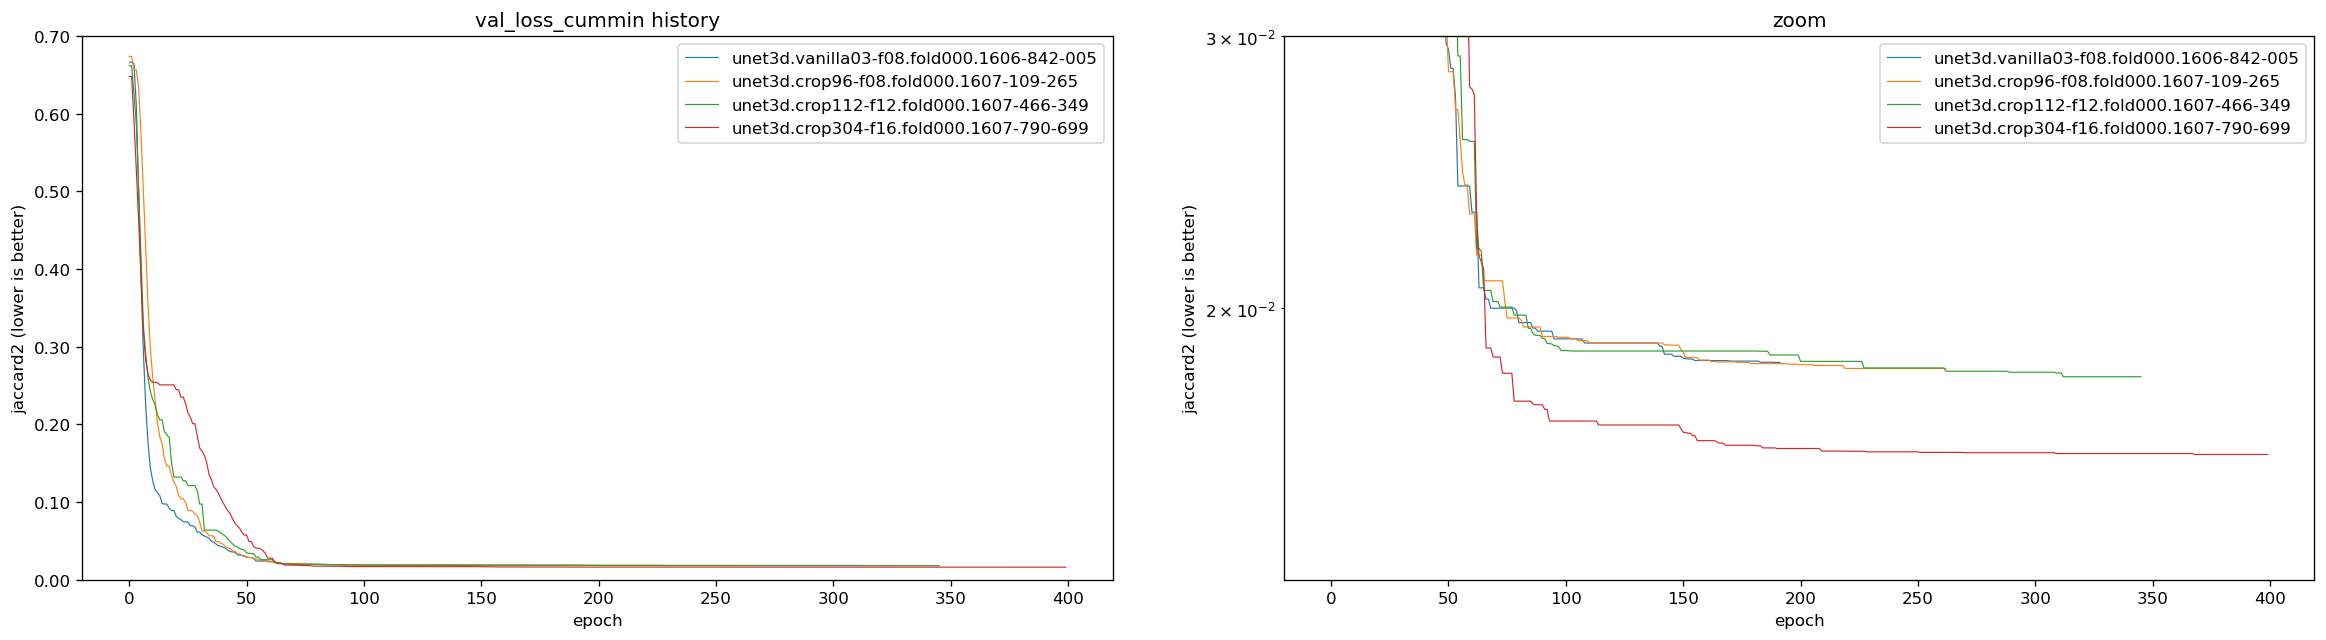

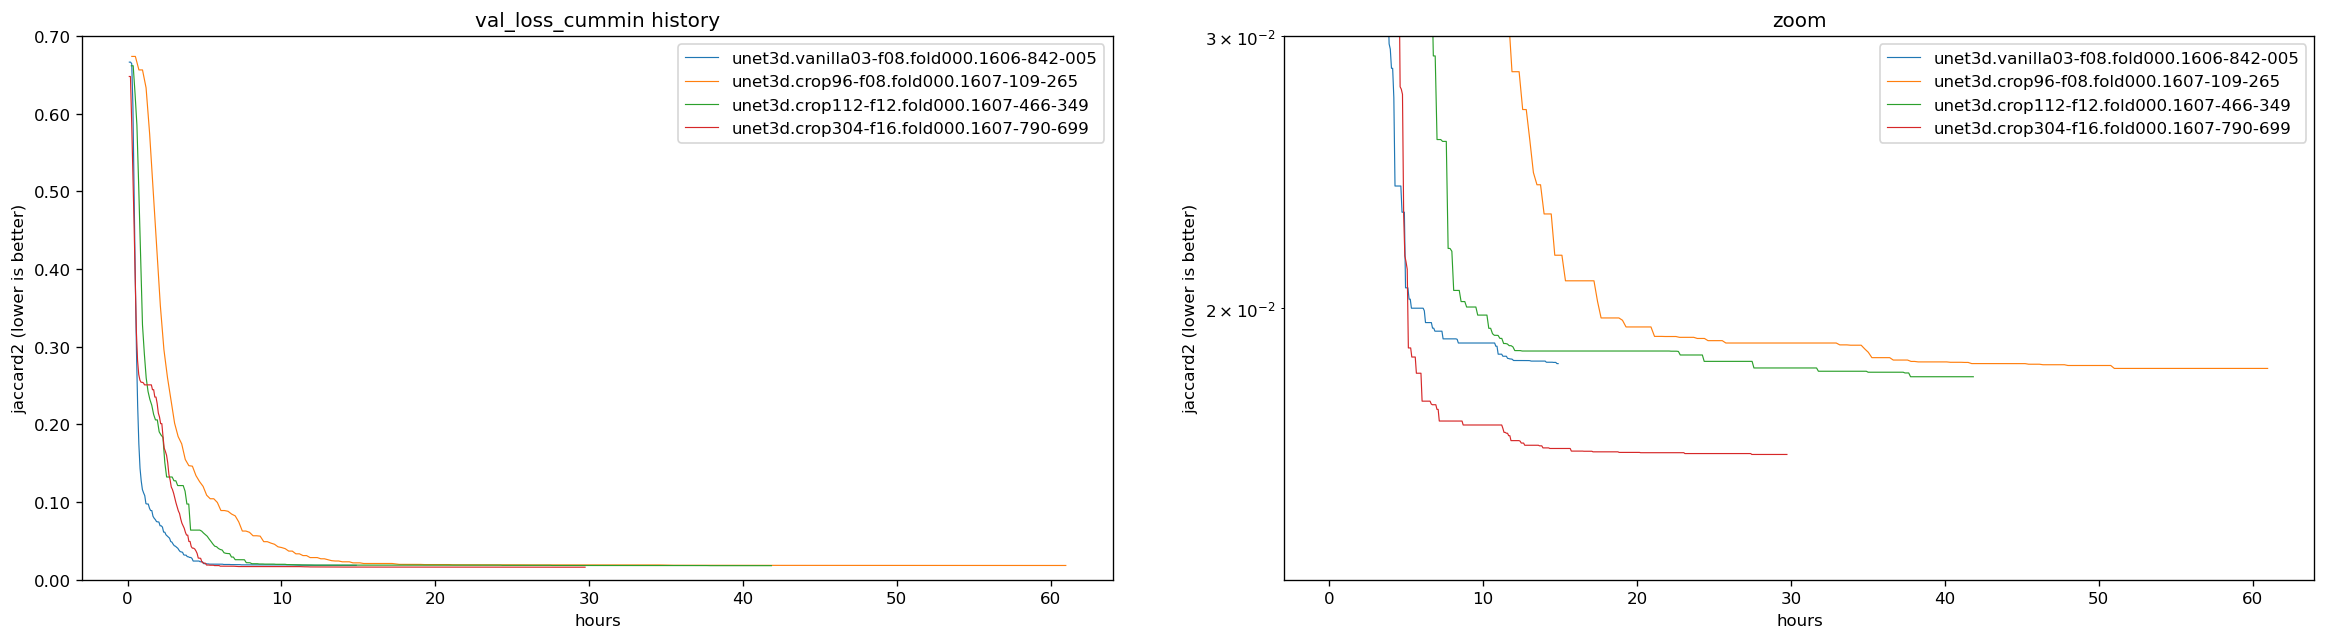

In [217]:
# plot("epoch", "val_loss", compare_crop_sizes, color_map)
# plot("hours", "val_loss", compare_crop_sizes, color_map)
plot("epoch", "val_loss_cummin", compare_crop_sizes, color_map)
plot("hours", "val_loss_cummin", compare_crop_sizes, color_map)